# From H5 file to turbidity scores
This tutorial shows how to calculate a turbidity like metric for ICESat-2 photon data using OpenOceans. Beginning with a full-size or already spatially subset H5 file from NSIDC and a study area, the photon data is binned and analyzed in along track steps before fitting a 3-part pseudo lidar waveform return model.

Last Updated: Jan 6, 2023 </br>
**Jonathan Markel** </br>
Graduate Student, UT Austin</br>


In [1]:
# importing common packages, as well as OpenOceans code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from scipy.signal import savgol_filter, correlate
import statsmodels.api as sm
from hurst import compute_Hc, random_walk


sys.path.append('/Users/jonathan/Documents/Research/OpenOceans')
import openoceans as oo


## Define Study Area / Profile Of Interest

Lets identify our H5 file and load in the track data, before applying a bounding box to subset the data. If you havent already, you can download an ICESat-2 pass over the Pamlico Sound in North Carolina. It is a full size ATL03, which we will spatially subset and process. [Download the ATL03 file via this Box Link](https://utexas.box.com/s/28544lhsnuilfd6peqf63plyf4au73vs).

In [2]:
# define AOI, use geojson of small NC region
AOI = oo.GeoAOI.from_geojson('demo_data/pamlico.geojson')
AOI.explore()

In [3]:
h5_filepath = '../sample_data/north_carolina_ATL03_20191024144104_04230506_005_01.h5'

p = oo.Profile.from_h5(h5_filepath, 'gt2l', aoi=AOI, verbose=False)

print(p)


TRACK DETAILS
    D/M/Y: 24/10/2019
    Reference Ground Track: 423
    Cycle: 5
    Region: 6
    Orbit Direction: DESCENDING
    Release: 005

BEAM DETAILS
    GT2L
    WEAK BEAM
    ATLAS SPOT 4 
    
ICESat-2 Profile: ATL03_20191024*_04230506_005
Photons Returned: 133104



The explore method will open a browser tab and interactive Bokeh plots for exploring the data and comparing to imagery.

In [4]:
# p.explore()

## Histogram Modeling and Pseudowaveforms

Now that we know how to read in, store, and work with ICESat-2 photon data, lets focus on analysis. We use a 3-part histogram-based model, as described in other literature. When processing multiple tracks, we want to make sure we're consistent in how we apply the model to each profile. To achieve this, we use a ModelMaker object.

We'll construct a model using 250m along track bins, histogramming photon data between -50 and +20 geoidal elevation in 0.25m vertical bins. Additionally, for each step we take along track, we'll use a window of 1 (only looking at this along track bin).

Pending further optimization of how model parameters get initialized, we apply a preliminary, iterative curve fitting procedure to tighten up the models accuracy. We'll see some optimization warnings (silenced), and this might run a little slower than absolutely necessary. This is separate from the `fit` parameter in the Models, which runs a final optimization over the combined model. We only run the preliminary version which fits the individual model components.

In [5]:
import warnings
warnings.filterwarnings("ignore")

100%|██████████| 126/126 [00:03<00:00, 40.91it/s]


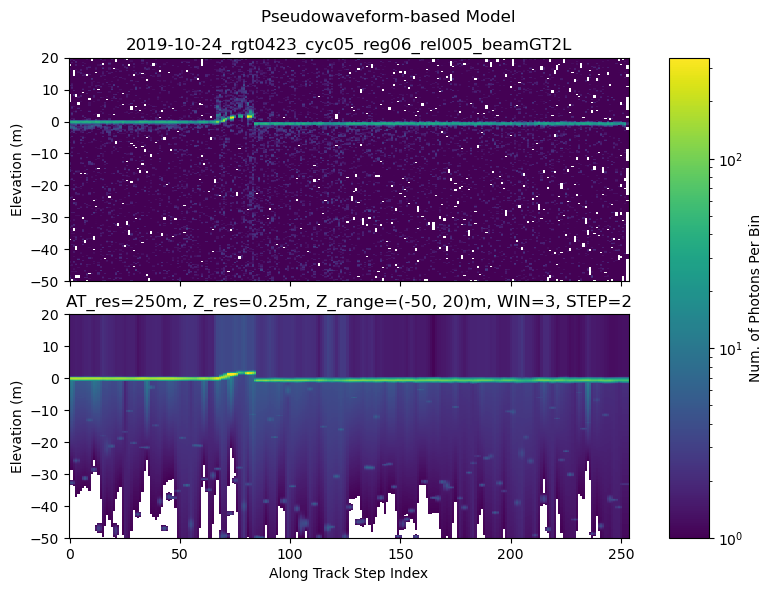

In [6]:
# create a model maker
M = oo.ModelMaker(res_along_track=250,
                  res_z=0.25,
                  range_z=(-50, 20),
                  window_size=3,
                  step_along_track=2, 
                  fit=False, verbose=False)

# use the parameters of this model to process the profile from before
m = M.process(p)

# vizualize overally quality of model fit in terms of resolution/scale
_ = m.show()

Recall that the model is basically made of a bunch of fitted histograms along track. We can inspect the quality of individual models to get a sense of how well the model is matching our expectations. (Note log axes!)

At the moment, individual waveforms are indexed by the along track bin at the center of the window. For step_along_track = 1, its just the standard integer index. See demo 3 for more on working with waveforms. We'll look around the middle of the open water section of the along track, and pick an i anywhere from about 50-250, lets go with 130 for now.

A quick stipulation that the plot below axes aren't really 'depth', that is, the surface location is non-zero. A better y label would be '(-) Elevation EGM08 (m)'

In [7]:
m.waves

{1: <openoceans.waveform.Waveform at 0x195d560e0>,
 3: <openoceans.waveform.Waveform at 0x195d569e0>,
 5: <openoceans.waveform.Waveform at 0x195d563b0>,
 7: <openoceans.waveform.Waveform at 0x195d565f0>,
 9: <openoceans.waveform.Waveform at 0x195d56050>,
 11: <openoceans.waveform.Waveform at 0x195d56650>,
 13: <openoceans.waveform.Waveform at 0x195d56800>,
 15: <openoceans.waveform.Waveform at 0x195d564d0>,
 17: <openoceans.waveform.Waveform at 0x199287370>,
 19: <openoceans.waveform.Waveform at 0x195d56d10>,
 21: <openoceans.waveform.Waveform at 0x199287160>,
 23: <openoceans.waveform.Waveform at 0x195d56260>,
 25: <openoceans.waveform.Waveform at 0x199286b30>,
 27: <openoceans.waveform.Waveform at 0x195d56350>,
 29: <openoceans.waveform.Waveform at 0x195a13df0>,
 31: <openoceans.waveform.Waveform at 0x195d56380>,
 33: <openoceans.waveform.Waveform at 0x195a13640>,
 35: <openoceans.waveform.Waveform at 0x195d56830>,
 37: <openoceans.waveform.Waveform at 0x199287310>,
 39: <openoceans.

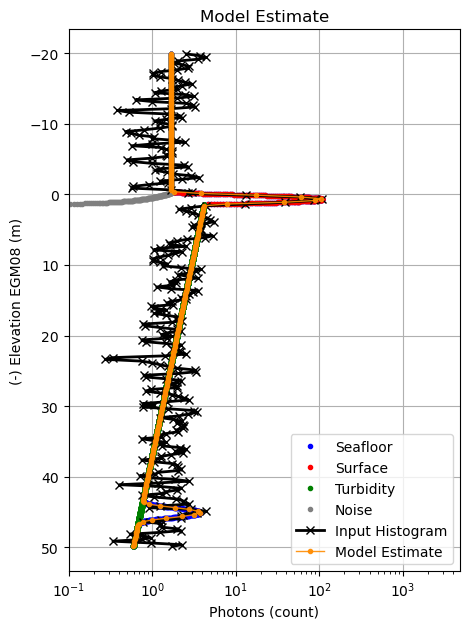

In [8]:
w = m.waves[131]
_ = w.show(logplot=True)
# w.profile.data.columns

,input,depth,output,noise,surface,bathy,turbidity,output_f,noise_f,surface_f,bathy_f,turbidity_f
0,2.568377,-19.875,1.685373,1.685373,0.0,0.0,0.0,-1.0,NaN,NaN,NaN,NaN
1,3.726546,-19.625,1.685373,1.685373,0.0,0.0,0.0,-1.0,NaN,NaN,NaN,NaN
2,4.387362,-19.375,1.685373,1.685373,0.0,0.0,0.0,-1.0,NaN,NaN,NaN,NaN
3,3.497795,-19.125,1.685373,1.685373,0.0,0.0,0.0,-1.0,NaN,NaN,NaN,NaN
4,2.024998,-18.875,1.685373,1.685373,0.0,0.0,0.0,-1.0,NaN,NaN,NaN,NaN


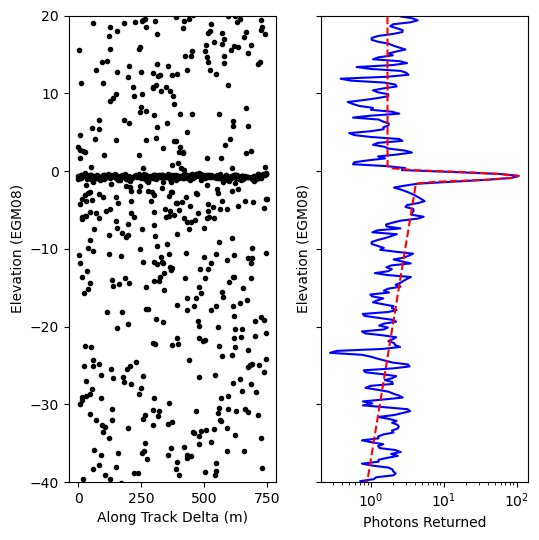

In [9]:
# we can also manually inspect and manipulate individual waveform data at this level

# photon data
along_track_distance = w.profile.data.dist_ph_along
geoidal_height = w.profile.data.height - w.profile.data.geoid_z
input_histogram_data = w.model.input
output_modeled_data = w.model.output
elevations = -w.model.depth

# plot the photon and waveform data
f,ax = plt.subplots(1, 2, sharey=True, figsize=(5.5, 5.5))
ax[0].plot(along_track_distance - min(along_track_distance), geoidal_height, 'k.')
ax[0].set_ylabel('Elevation (EGM08)')
ax[0].set_xlabel('Along Track Delta (m)')

ax[1].plot(input_histogram_data, elevations, 'b')
ax[1].plot(output_modeled_data, elevations, 'r--')
ax[1].set_ylabel('Elevation (EGM08)')
ax[1].set_xlabel('Photons Returned')
ax[1].set_xscale('log')

ax[0].set_ylim([-40, 20])
f.tight_layout()
w.model.head()


## Exploring Model Parameters

Calculating a turbidity score as the discrete integral of the exponential decay component...

df = m.params
df.loc[:, 'turb_score'] = 0

for i in m.params.index:
    # integral of turbidity model
    df.loc[i, 'turb_score'] = np.sum(m.waves[i].model.turbidity)

### Plotting Model Parameters with Along Track Photon Data

Keep in mind the model does not really distinguish between land and surface at this point in time, so results over land will not be as expected and should be filtered out as best as possible by the user, however they see fit. Recommended options are clipping to known shorelines, using an a prior water line max, setting a threshold for the bathy return prominence etc...

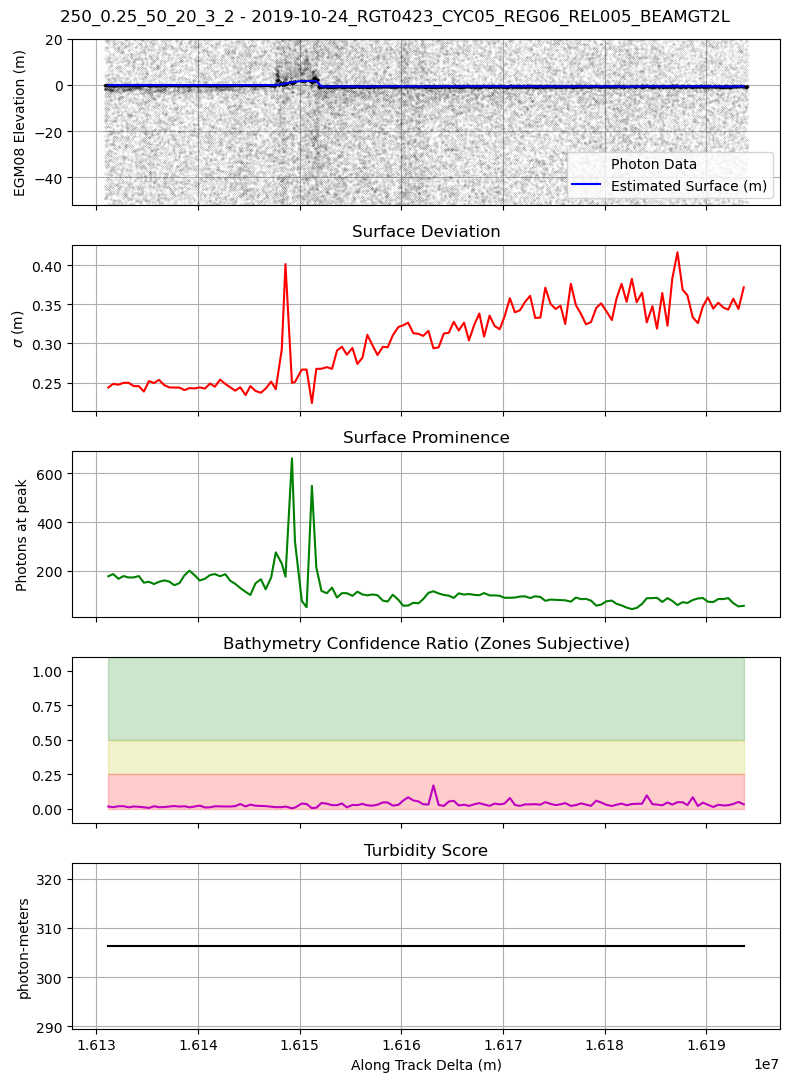

In [10]:
# input model maker from before
f, ax = m.report(M) 

Because the model affords clear delineations between surface, water column, and bathy - we can straightforwardly map a rudimentary photon label for the original point cloud. Notice that the `classification` field of the photon data should now have actual classifications!

In [11]:
labels = m.label_photons()
m.profile.data.classification = labels
m.profile.data.classification.value_counts()

 2     47903
 1     33701
 41    29414
 45    19976
 40     2067
-1        43
Name: classification, dtype: int64

This code uses the LAS topobathy specification class where applicable. Label 1 corresponds to returns above the water/primary surface, label 2 is for photons below any identified bathy of any confidence. Photons not labeled for whatever reason are labeled -1. These should be considered very naive classifications in need of further filtering before use.

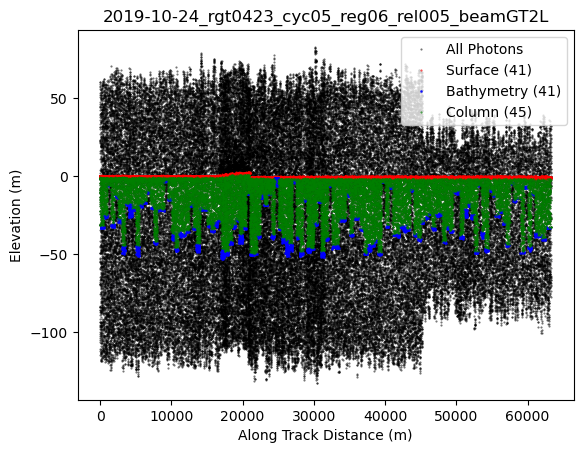

In [12]:
# show_photons checks if the classifications have been made, and if so, plots them

_, _ = m.profile.show_photons()

Still need to make it filter by bathy confidence, but first I want to get a rough estimate of surface vs not surface.

In [13]:
# throwing errors for now when non-1 step size is used
# likely_land_bins = m.classify_land(window_size=21)
# m.plot_land_classification()

In [14]:
import scipy.stats as stats

# use a ttest to check if a set of values are meaningfully different from zero
def effectively_zero(values):

    if len(values) < 2:
        # not enough data to make a meaningful comparison
        return False

    t, p = stats.ttest_1samp(values, 0)

    return p > 0.05

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


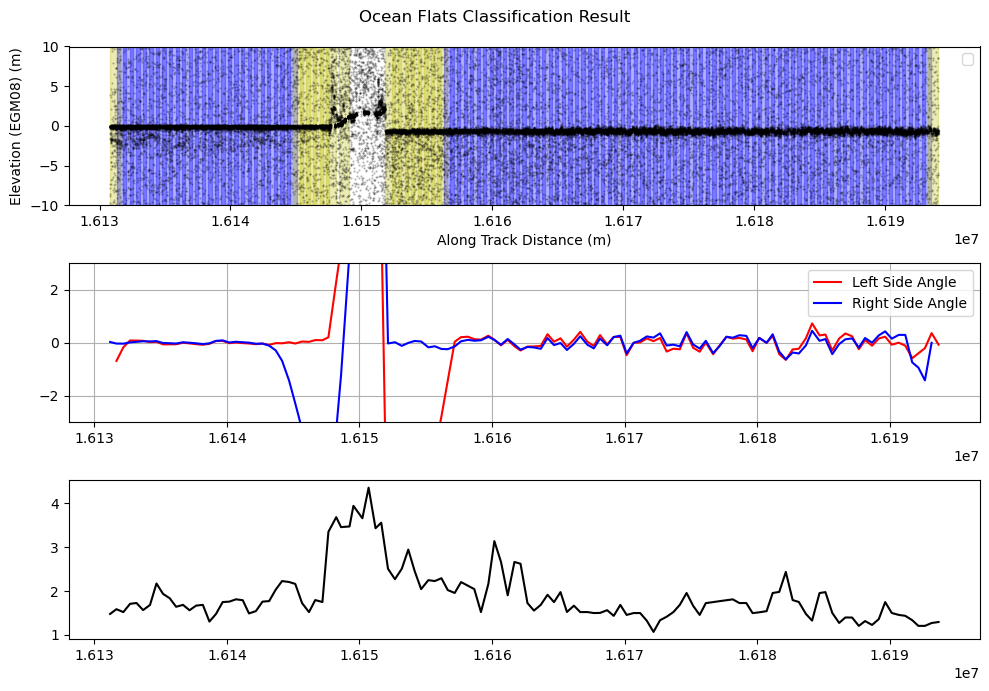

In [15]:
window_size=21
degree_threshold = 2

# this is an algorithm to identify ocean bins by checking nearly bins for a locally flat surface
assert window_size % 2 == 1, 'window size must be odd'

win_half = int((window_size - 1) / 2)

angle_L = np.full((m.params.shape[0], ), -999., dtype=np.float64)
angle_R = np.full((m.params.shape[0], ), -999., dtype=np.float64)

for i_along_track in range(m.params.shape[0]):
    
    params_i = m.params.iloc[i_along_track, :]

    # looking at in bins ahead of central value (RIGHT SIDE)
        # require at least 2 bins on either side
    if i_along_track + min([win_half, m.params.shape[0]]) <=2:
        small_flank_R = True
    else: 
        small_flank_R = False

    if i_along_track + win_half > m.params.shape[0]:
        right = m.params.shape[0] - 1
    else:
        right = i_along_track + win_half

    # collect values to some distance either side
    params_R = m.params.iloc[i_along_track:right, :]

    # given some central bin, calculate the mean of all the bin surface heights on a given side
    # basic trig
    opposite_side_R = params_R.surf_loc.mean() - params_i.surf_loc
    adjacent_side_R = np.abs(right - i_along_track)
    angle_R[i_along_track] = np.arctan2(opposite_side_R, adjacent_side_R)

    # LEFT SIDE
    if i_along_track - max([win_half, 0]) <=2:
        small_flank_L = True
    else: 
        small_flank_L = False

    if i_along_track - win_half < 0:
        left = 0
    else:
        left = i_along_track - win_half
    
    params_L = m.params.iloc[left:i_along_track, :]
    opposite_side_L = params_L.surf_loc.mean() - params_i.surf_loc
    adjacent_side_L = np.abs(i_along_track - left)
    angle_L[i_along_track] = np.arctan2(opposite_side_L, adjacent_side_L)

    # check if data on either given side is 'flat' 
    # are either of tho angles smaller than 5 degrees?
    angle_R_deg = angle_R[i_along_track] * 180 / np.pi
    angle_L_deg = angle_L[i_along_track] * 180 / np.pi
    flat_condition_R = (np.abs(angle_R_deg) < degree_threshold)
    flat_condition_L = (np.abs(angle_L_deg) < degree_threshold)
    
    if flat_condition_R & flat_condition_L:
        m.params.water_conf[i_along_track] = 2 # high confidence

    elif flat_condition_R | flat_condition_L:
        m.params.water_conf[i_along_track] = 1 # medium confidence

    else:
        m.params.water_conf[i_along_track] = 0 # low/no confidence


smallest_angle_deg = np.nanmin(np.vstack([angle_R, angle_L]), axis=0) * 180 / np.pi

# PLOTTING
f, ax = plt.subplots(3, 1, figsize=(10, 7))

# plot photon data
z = m.profile.data.height - m.profile.data.geoid_z
ax[0].plot(m.profile.data.dist_ph_along, z, 'k.', markersize=1, alpha=0.3)

# for i in range(m.bin_edges_at)
y_range = [z.min(), z.max()]

for i in range(m.params.shape[0]):

    i_bin_edges = m.params.at_range[i]

    if m.params.water_conf[i] == 2:
        ax[0].fill_betweenx(y_range, i_bin_edges[0], i_bin_edges[1], color='b', alpha=0.3)

    elif m.params.water_conf[i] == 1:
        ax[0].fill_betweenx(y_range, i_bin_edges[0], i_bin_edges[1], color='y', alpha=0.3)
    else:
        pass
        # ax[0].fill_betweenx(y_range, i_bin_edges[0], i_bin_edges[1], color='grey', alpha=0.3, label='Low/No Confidence')

ax[0].set_xlabel('Along Track Distance (m)')
ax[0].set_ylabel('Elevation (EGM08) (m)')
ax[0].set_ylim([-10, 10])
ax[0].legend()
f.suptitle('Ocean Flats Classification Result')

ax[1].plot(m.params.at_med, angle_L * 180 / np.pi, 'r', label='Left Side Angle')
ax[1].plot(m.params.at_med, angle_R * 180 / np.pi, 'b', label='Right Side Angle')
ax[1].grid()
ax[1].legend()
ax[1].set_ylim([-3, 3])

# use a high 'noise above' rating to lower water conf scores
ax[2].plot(m.params.at_med, m.params.noise_above, 'k')

f.tight_layout()

## Testing Open Water Frequency Application

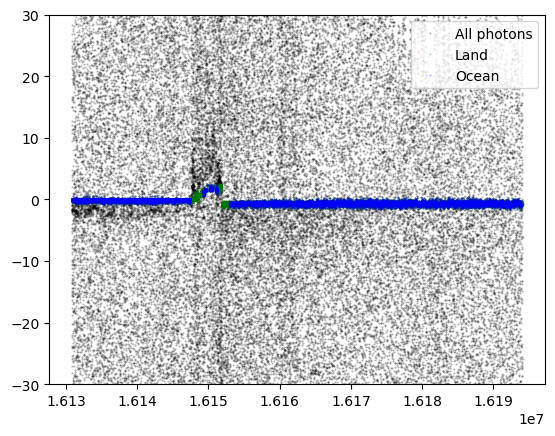

In [16]:
# integrated into open oceans

m.is_water # photon resolution water flag


z_ph = m.profile.data.height - m.profile.data.geoid_z
x_ph = m.profile.data.dist_ph_along


# water index is same dimensions as surface photons only
x_surf = x_ph[m.profile.data.classification==41].values
z_surf = z_ph[m.profile.data.classification==41].values
water_idx = m.is_water.astype(bool)


f, ax = plt.subplots()
plt.plot(x_ph, z_ph, 'k.', markersize=1, alpha=0.3, label='All photons')
plt.plot(x_surf, z_surf, 'g.', markersize=1, alpha=0.3, label='Land')
plt.plot(x_surf[water_idx], z_surf[water_idx], 'b.', markersize=1, alpha=0.3, label='Ocean')
plt.ylim(-30, 30)
plt.legend()

,0,1,2
0,1,2,3
1,5,6,7


### Old testing code

We assume that open water shows some periodicity in surface returns over large enough length scales. Accordingly, check the data on either side of our target bin. Because large bins (200m+) might average out or alias smaller wavelengths, we want to have as high resolution of surface signal as possible. Classifying any photons in a bin that fall between 3 $\sigma$ above the surface and the transition to the water column gives us a solid enough first surface estimate. We then smooth that surface data to reduce noise while retaining wave structure. Then that signal is analyzed in the frequency domain to look for dominant features. The assumption is that topography is very rarely naturally periodic near coastlines, and strong surface returns make wavy signal easy to consistently identify.

In [18]:
def psd_ratio(signal):
    # Compute the FFT of the signal
    fft = np.fft.fft(signal)
    
    # Compute the PSD of the signal
    psd = np.abs(fft)**2
    
    # Find the frequency at which the PSD is maximum
    max_freq = np.argmax(psd)
    
    # Calculate the ratio of the maximum PSD value to the mean of the PSD values
    psd_ratio = psd[max_freq] / np.mean(psd)

    return psd_ratio 


In [19]:
def count_squiggles(signal):

    # counts the number of times a 1-D signal changes direction

    signal_slope = np.diff(signal)

    sign_changes = 0
    for i in range(1, len(signal_slope)):
        if (signal_slope[i] < 0 and signal_slope[i-1] >= 0) \
            or (signal_slope[i] >= 0 and signal_slope[i-1] < 0):
            sign_changes += 1

    return sign_changes


Taking a closer look near the shoreline to test the photon collection and frequency analysis.

In [20]:
# faster way to check each window if you want to go straight to the photon data

def get_photons_in_window(model_output_bin_idx, along_track_sight_distance, model):
    """
    This function will collect the photons ahead or behind you, depending on which model output bin you're on, for further analysis.

    The intended application is to return photons for surface wave analysis.
    """
    m = model

    this_chunk = m.params.loc[m.params.i==model_output_bin_idx, :]

    this_at_center = this_chunk.at_med.iloc[0]

    # (center bin, look ahead distance)
    at_range_ahead = (this_at_center, this_at_center + along_track_sight_distance)

    # (center bin, look behind distance)
    at_range_behind = (this_at_center - along_track_sight_distance, this_at_center)

    # get all photons ahead/behind you
    photons_ahead = m.profile.data.loc[(m.profile.data.dist_ph_along > at_range_ahead[0]) & (m.profile.data.dist_ph_along < at_range_ahead[1]), :]  
    photons_behind = m.profile.data.loc[(m.profile.data.dist_ph_along > at_range_behind[0]) & (m.profile.data.dist_ph_along < at_range_behind[1]), :]
    

    return photons_ahead, photons_behind

def smooth_nearby_surface(nearshore_bin, along_track_sight_distance, model, smoothing_aggression=0.05):
    # this needs to be several different functions
    
    photons_ahead, photons_behind = get_photons_in_window(nearshore_bin, along_track_sight_distance, model)

    # now only ones classified surface
    surface_photons_ahead = photons_ahead.loc[photons_ahead.classification == 41, :]
    surface_photons_behind = photons_behind.loc[photons_behind.classification == 41, :]

    # simplifying and applying geoid correction
    x_L = surface_photons_behind.dist_ph_along
    z_L = surface_photons_behind.height - surface_photons_behind.geoid_z

    x_R = surface_photons_ahead.dist_ph_along
    z_R = surface_photons_ahead.height - surface_photons_ahead.geoid_z

    #  smooth this surface photon data with a 1 dimensional median filter

    # smoothing_aggression = 0.025 # 0.1 to 0.9
    # basically a fraction of how big the smoothing window is relative to the overall array
    # best around 0.01-0.2

    window_length_R = np.int64(z_R.shape[0] * smoothing_aggression)
    window_length_L = np.int64(z_L.shape[0] * smoothing_aggression)

    # window length must be odd
    if window_length_R % 2 == 0:
        window_length_R += 1

    z_R_filter = savgol_filter(z_R, window_length_R, 3)
    z_L_filter = savgol_filter(z_L, window_length_L, 3)

    right_surface = pd.DataFrame(np.vstack([x_R, z_R, z_R_filter]).T, columns=['x', 'z', 'z_smoothed'])
    left_surface = pd.DataFrame(np.vstack([x_L, z_L, z_L_filter]).T, columns=['x', 'z', 'z_smoothed'])

    return left_surface, right_surface

In [21]:
def plot_surfaces(left_surface, right_surface):
    #### PLOTTING
    # Smoothed surfaces 
    f, ax =  plt.subplots(1, 2, figsize=(13, 3))

    ax[0].plot(left_surface.x, left_surface.z, 'k.', label='Raw')
    ax[0].plot(left_surface.x, left_surface.z_smoothed, 'r.', label='Smoothed')
    ax[0].set_xlabel('Along Track Distance (m)')
    ax[0].set_ylabel('Elevation (m)')
    ax[0].legend()


    ax[1].plot(right_surface.x, right_surface.z, 'k.', label='Raw')
    ax[1].plot(right_surface.x, right_surface.z_smoothed, 'r.', label='Smoothed')
    ax[1].set_xlabel('Along Track Distance (m)')
    ax[1].set_ylabel('Elevation (m)')
    ax[1].legend()

    return f, ax

In [22]:
def cosine_similarity(x, y):
    """
    Compute the cosine similarity between two signals.
    
    Parameters:
    x (1D array): First signal.
    y (1D array): Second signal.
    
    Returns:
    float: Cosine similarity between x and y.
    """
    # Compute dot product and magnitudes
    dot = np.dot(x, y)
    x_mag = np.linalg.norm(x)
    y_mag = np.linalg.norm(y)
    
    # Compute and return cosine similarity
    return np.real(dot / (x_mag * y_mag))

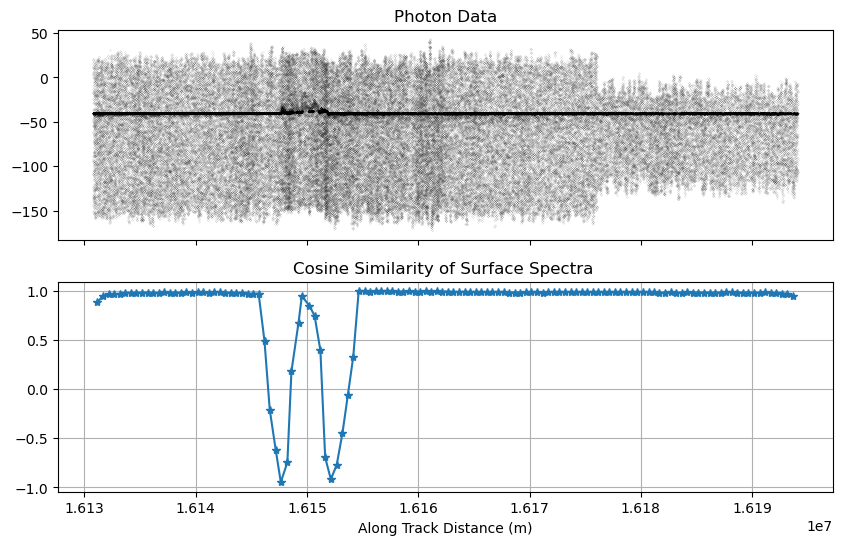

In [23]:
# for debugging
score_L = -np.ones((m.params.shape[0], ))
score_R = -np.ones((m.params.shape[0], ))

freq_diff_score = -np.ones((m.params.shape[0], ))
cosine_similarity_score = -np.ones((m.params.shape[0], ))

# bin_selections = [15, 43]
bin_selections = m.params.index

debugMe = False

for ii in bin_selections:
        
    if debugMe: 
        print(f'####################   {ii}   #####################')
        
    along_track_sight_distance = 3000 # how far to look in each direction
    nearshore_bin = m.params.i.iloc[ii]

    # get smoothed surface for this range
    left_surface, right_surface = smooth_nearby_surface(nearshore_bin, along_track_sight_distance, m, 
        smoothing_aggression=0.05)

    if debugMe:
        plot_surfaces(left_surface, right_surface)

    # compute autocorrelation of surface on either side of you
    surf_autocorr_L = sm.tsa.stattools.acf(left_surface.z_smoothed, 
                            nlags=len(left_surface.z_smoothed))

    surf_autocorr_R = sm.tsa.stattools.acf(right_surface.z_smoothed, 
                            nlags=len(right_surface.z_smoothed))

    # count the number of features
    score_L[ii] = count_squiggles(surf_autocorr_L)

    score_R[ii] = count_squiggles(surf_autocorr_R)

    # print(score_L[ii], score_R[ii])

    # alternative, simpler approach
    # compare surface on either side to each other
    # assumes waves are basically the same on either side

    # make the same length
    trim_length = min([len(left_surface.z_smoothed), len(right_surface.z_smoothed)])
    # get this chunk from end of array
    surf_sig_L = left_surface.z_smoothed[-trim_length:]
    surf_sig_R = right_surface.z_smoothed[:trim_length]
    
    surf_xcorr = np.corrcoef(surf_sig_L, surf_sig_R,)
    # print(surf_xcorr[0, 1])
    # isnt working as well as i'd like

    # is the principle that the surface is the same on either side
    # or that the frequency content is the same
    # compare the frequcny domain of the two surfaces, basic comparison
    # need to find someway to make an absolute metric

    # use fft to get freq response
    freq_L = np.fft.fft(surf_sig_L)
    freq_R = np.fft.fft(surf_sig_R)

    # cut duplicate frequencies
    freq_L = freq_L[:int(len(freq_L)/2)]
    freq_R = freq_R[:int(len(freq_R)/2)]

    freq_diff_score[ii] = np.sqrt(np.mean((freq_L - freq_R)**2))

    # instead of the diff score, compare cosine similarity of SPECTRA
    cosine_similarity_score[ii] = cosine_similarity(freq_L, freq_R)
    

f, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 6))

ax[0].plot(m.profile.data.dist_ph_along, m.profile.data.height, 'k.', markersize=0.1, label='Raw')
ax[0].set_title('Photon Data')
# ax[1].plot(m.params.at_med, freq_diff_score, '-*')
# ax[1].set_title('RMSE of Freq Domain')
# ax[1].set_ylim([0, 20])

ax[1].plot(m.params.at_med, cosine_similarity_score, '-*')
ax[1].set_title('Cosine Similarity of Surface Spectra ')
ax[1].set_xlabel('Along Track Distance (m)')
ax[1].grid()

# ax[2].plot(m.params.at_med, score_L, 'r.', label='L SCORE')
# ax[2].plot(m.params.at_med, score_R, 'b.', label='R SCORE')
# ax[2].legend()
# ax[2].set_title('Autocorr Approach')
# ax[2].set_xlabel('Along Track Distance (m)')

# maybe threshold of 20 for gt3r

# lower threshold for gt1l, like 10

# f.suptitle('Land vs Ocean Metric Testing')


In [24]:
# probably best alongside a flatness metric, as this still has false positives
# but much lower rate and different failure mode